# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Нам же необходимо построить модель, которая умеет её определять. В нашем распоряжении есть такие исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В представленных нам данных такие признаки:

- ```DateCrawled``` — дата скачивания анкеты из базы
- ```VehicleType``` — тип автомобильного кузова
- ```RegistrationYear``` — год регистрации автомобиля
- ```Gearbox``` — тип коробки передач
- ```Power``` — мощность (л. с.)
- ```Model``` — модель автомобиля
- ```Kilometer```— пробег (км)
- ```RegistrationMonth``` — месяц регистрации автомобиля
- ```FuelType``` — тип топлива
- ```Brand``` — марка автомобиля
- ```Repaired``` — была машина в ремонте или нет
- ```DateCreated``` — дата создания анкеты
- ```NumberOfPictures``` — количество фотографий автомобиля
- ```PostalCode``` — почтовый индекс владельца анкеты (пользователя)
- ```LastSeen``` — дата последней активности пользователя

Целевой признак:
- ```Price``` — цена (евро)


Для решения задачи мы будем придерживатья следующих шагов:

1. Изучим и подготовим для машинного обучения данные

2. Создадим несколько видов ML-моделей, основанных на разных алгоритмах

3. Выберем лучший алгоритм по ряду параметров и посчитаем на нём контрольную метрику на тестовых данных

4. Подведём итог проделанной работе

_____

## Подготовка данных

Установим небольшую библиотечку для цветного шрифта:

In [1]:
!pip install colorama

Defaulting to user installation because normal site-packages is not writeable


Импортируем библиотеки и момодули, необходимые для работы:

In [2]:
import itertools
import os
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from colorama import Fore, Style
from scipy import stats
from scipy.stats import norm

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('max_colwidth', 1000)
RANDOM_STATE = 42

Техническая часть работы - все классы, функции и пр. рабочие части кода соберём в одном месте здесь наверху, так общий код исследования будет выглядеть аккуратнее:

In [3]:
def get_info(df):
    """
    функция выводит общую статистику по датафрейму и отрисовывает графики по каждому признаку:
    - для признаков типа int гистограмму
    - для признаков типа object круговую диаграмму
    - для признаков с количеством значений > 10000 шт. - ничего
    """
    
    s_br, s_reset = Style.BRIGHT, Style.RESET_ALL
    display(df.head(3), df.tail(3), df.describe().T)

    num_cols, cat_cols = [], []
    for num, i in enumerate(df.columns):
        if pd.api.types.is_numeric_dtype(df[i]):
            print(f'{num+1}) {s_br}{i}{s_reset} (тип int), оригинальных значений: {len(df[i].unique())}')
            num_cols.append(i)
        elif pd.api.types.is_object_dtype(df[i]):
            print(f'{num+1}) {s_br}{i}{s_reset} (тип object), оригинальных значений: {len(df[i].unique())}')
            cat_cols.append(i)
    print(f'\n{s_br}итого:{s_reset}\nтип int: {len(num_cols)}\nтип object: {len(cat_cols)}\n'
          f'\n{s_br}пропуски:{s_reset}\n{df.isna().sum()}\n\n{s_br}дубликатов:{s_reset} {df.duplicated().sum()}')
    
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
    fig.suptitle('распределение значений признаков', fontsize=16, fontweight='bold')

    for num, col_name in enumerate(df.columns):
        row = num // 4
        col = num % 4
        if df[col_name].nunique() > 10000: 
            ax[row][col].set_title(col_name)
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            continue
        if col_name in num_cols: 
            ax[row][col].hist(df[col_name].dropna(), color='#4C72B0', edgecolor='#5AB3CB', bins=20)
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
        else:
            counts = df[col_name].dropna().value_counts()
            ax[row][col].pie(counts.values.tolist(), startangle=90, 
                             wedgeprops={'linewidth': .7, 'edgecolor': 'white'})
        ax[row][col].set_title(col_name)
    plt.subplots_adjust(hspace=.5, wspace=.3);
    
    
def get_date_information(df, col_name):
    """
    функция преобразует столбец датафрейма в формат даты и выводит информацию о нем, 
    включая минимальное и максимальное значение, количество уникальных значений
    """
    
    df[col_name] = pd.to_datetime(df[col_name]).dt.date
    print(f'{Style.BRIGHT}Признак {df[col_name].name}{Style.RESET_ALL}\nминимум: {df[col_name].min()}\n'
          f'максимум: {df[col_name].max()}\nуникальных значений: {df[col_name].nunique()}\n')
    

def quantile_confidence_interval(data, confidence_level=.95, get_print=False):
    """
    функция вычисляет доверительный интервал для среднего значения числового столбца `data` 
    с заданным уровнем доверия `confidence_level`. 
    Возвращает функция нижнюю и верхнюю границы доверительного интервала.
    """
    
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    alpha = 1 - confidence_level
    z_score = norm.ppf(1 - alpha / 2)
    lower_bound = mean + z_score * std_err
    upper_bound = mean - z_score * std_err
    if get_print:
        print(f'Доверительный интервал для среднего значения {data.name}: \n\t'
              f'[{upper_bound:.2f}, {lower_bound:.2f}]') 
    return lower_bound, upper_bound

def get_bar(x, y, xlabel, ylabel, title, rotation=0, h=False, rmse_=False):
    """Функция отрисовывает столбчатую диаграмму (горизонтальную или вертикальную)"""
    
    if h:
        plt.figure(figsize=(12, 7))
        plt.barh(x, y, color='#A0E4BD', ec='#7DA990')
        axis_ = 'x'
    else:
        plt.figure(figsize=(12,4))
        plt.bar(x, y, color='#A0E4BD', ec='#7DA990')
        axis_ = 'y'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight='bold')
    plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', axis=axis_, linewidth=.5)
    plt.grid(which='minor', axis=axis_, linewidth=.25, linestyle='--')
    if rmse_ is not False:
        for i, v in enumerate(rmse_):
            plt.text(i-.10, v-500, str(round(v, 2)), fontweight='bold', fontsize=14);
    
    
def get_heatmap(df, col_1, col_2, col_3, title):
    """функция строит тепловую карту по сгруппированным столбцам"""
    
    df_count = df.groupby([col_1, col_2]).count()[col_3].reset_index()
    df_pivot = df_count.pivot_table(index=col_1, columns=col_2, values=col_3)

    # заменить значения столбца с помощью словаря
    df_pivot.columns = df_pivot.columns.map(plz_dict)

    plt.figure(figsize=(10, 7))
    plt.yticks(fontsize=7)
    plt.xticks(fontsize=8)
    sns.heatmap(df_pivot, cmap=plt.cm.BuGn, fmt='d', linewidths=.5, linecolor='#EAEDED', cbar=True)
    plt.title(title, fontweight='bold');
    
def fill_mode(group, column_name):
    """функция заполняет пропуски модой группы"""
    
    if group[column_name].notna().any():
        mode = stats.mode(group[column_name].dropna())[0][0]
        group[column_name].fillna(mode, inplace=True)
    return group


def get_distribution_of_values(data, bins=200, log_scale=False):
    """
    функция строит ящик с усами и гистограмму, отдельно гиперпараметрами
    можно передать количество бинов и лог.масштаб для оси X
    """
    
    fig, ax = plt.subplots(nrows=2, figsize=(12, 8))
    fig.suptitle(f'распределение значений для {data.name}', fontsize=16, fontweight='bold')
    sns.boxplot(x=data, width=.5, fliersize=2., color='#48B476', ax=ax[0])
    sns.histplot(data, bins=bins, color='#60C78C', edgecolor='#5E9073', ax=ax[1])
    ax[0].set_title('боксплот')
    ax[1].set_title('гистограмма')
    if log_scale:
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')
    ax[0].minorticks_on()
    ax[0].grid(which='major', linewidth=.5)
    ax[0].grid(which='minor', linewidth=.25, linestyle='--')
    ax[1].minorticks_on()
    ax[1].grid(which='major', linewidth=.5)
    ax[1].grid(which='minor', linewidth=.25, linestyle='--')
    fig.tight_layout();
    
    
def filtering_outliers_by_quantiles(df, col_name):
    """
    функция фильтрует выбросы в столбце, используя квантили, находя значения квантилей 0.025 и 0.975, 
    и оставляет только те строки, у которых значение столбца находится между этими квантилями. 
    Возвращается отфильтрованный датафрейм.
    """
    
    q_low = df[col_name].quantile(.025)
    q_high = df[col_name].quantile(.975)
    df_filtered = df[(df[col_name] > q_low) & (df[col_name] < q_high)]
    return df_filtered
    

def get_sns_histplot(df, xlabel, rotation=0):
    """функция строит seaborn-гистограмму с kde-линией"""

    plt.figure(figsize=(12,4))
    sns.histplot(df, kde=True, linewidth=5, ec='#60C78C')
    plt.xlabel(xlabel)
    plt.ylabel('количество')
    plt.title(f'распределение значений для {df.name}', fontweight='bold')
    plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--');
    

def get_lineplot(df, column_1, column_2, xlabel, ylabel):
    """функция строит линнейный график зависимости признаков"""
    
    df_mean = df[[column_1, column_2]].groupby(column_1).mean()
    plt.figure(figsize=(12, 4))
    sns.lineplot(x=column_1, y=column_2, data=df_mean, color='#60C78C', linewidth=4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'зависимость {df[column_2].name} от {df[column_1].name}', fontweight='bold')
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--');
    
    
class GetFinalTable:
    """класс в конструкторе заполняет финальную сводную таблицу с RMSE и замерами времени"""
    
    pivot_table = pd.DataFrame(columns=['модель', 'RMSE на train', 'RMSE на test', 
                                        'время на GridSearch', 'время на fit', 'время на predict'])
    
    def __init__(self, name_nodel, RMSE_train, RMSE_test, time_GS, time_fit, time_predict):
        self.model, self.RMSE_train = name_nodel, RMSE_train
        self.RMSE_test, self.t_GS = RMSE_test, time_GS
        self.t_fit, self.t_predict = time_fit, time_predict
        
        GetFinalTable.pivot_table.loc[len(GetFinalTable.pivot_table)] =\
        [self.model, self.RMSE_train, self.RMSE_test, self.t_GS, self.t_fit, self.t_predict]

In [4]:
format_time = lambda x: time.strftime('%H:%M:%S', time.gmtime(x))

def choosing_best_model(model, X, y, params, cv=2, linear_model=False, format_time=format_time,
                        X_test=False, y_test=False, sparse_output=True, ignore_categorical_features=False):
    """
    функция формирует пайплайн, передаёт его GridSearchCV, по сетке находит лучшие гиперпараметры,
    возвращает предсказания и экземпляр класса GetFinalTable, который дописывает в конец сводную таблицу,
    содержащую: название алгоритма с лучшими параметрами, замеры RMSE и время работы (GridSearchCV, fit, predict)
    """
    
    # запрещённый приём - списки сразу в функции, просто чтоб по 100 раз их не указывать при вызове
    categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                            'brand', 'repaired', 'postal_code', 'brand_popularity_index']
    numeric_features = ['power', 'kilometer', 'age', 'hp_per_kg', 'mileage_per_year']
    scorer = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred, squared=False))

    if ignore_categorical_features is False:

        preprocessor_cat = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=sparse_output)
        preprocessor_linear = ColumnTransformer(
            transformers=[('cat', preprocessor_cat, categorical_features),
                          ('num', StandardScaler(), numeric_features)])
        preprocessor_boosting_forest = ColumnTransformer(
            transformers=[('cat', preprocessor_cat, categorical_features),
                          ('num', 'passthrough', numeric_features)]) 

        # пайпланй для разных моделей
        if linear_model:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor_linear), 
                                       ('regressor', model)])
        else:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor_boosting_forest), 
                                       ('regressor', model)])
    else:
        # еслли ignore_categorical_features=True, то ничего не делаем с кат. признаками
        preprocessor_cat = FunctionTransformer(lambda x: x)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor_cat), 
                                   ('regressor', model)])        
        
    grid = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring=scorer, 
                        refit=False, error_score='raise', n_jobs=-1)
    
    time_grid = time.time()
    search = grid.fit(X, y)
    time_grid = format_time(time.time() - time_grid)
    
    # изменяем пайплайн, добавляя в него найденные лучшие гиперпараметры для модели
    pipeline.set_params(**search.best_params_)

    time_fit = time.time()
    pipeline.fit(X, y)
    time_fit = format_time(time.time() - time_fit)
    
    time_predict = time.time()
    y_pred = pipeline.predict(X)
    time_predict = format_time(time.time() - time_predict)
    rmse_y_pred = mean_squared_error(y, np.abs(y_pred), squared=False)
    
    # Если передали X_test и y_test, то предсказываем на них также
    if X_test is not False:
        y_pred_Xtest = pipeline.predict(X_test)
        rmse_y_pred_Xtest = mean_squared_error(y_test, np.abs(y_pred_Xtest), squared=False)
        table_row = GetFinalTable(str(pipeline[-1]), rmse_y_pred, 
                                  rmse_y_pred_Xtest, time_grid, time_fit, time_predict)    
        return pipeline, table_row, y_pred, np.abs(y_pred_Xtest)
    
    table_row = GetFinalTable(str(pipeline[-1]), rmse_y_pred, '',
                              time_grid, time_fit, time_predict)
    return pipeline, table_row, np.abs(y_pred)

_____

Скачаем файл и посмотрим на него:

In [5]:
try:
    df = pd.read_csv('_autos.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


1) DateCrawled (тип object), оригинальных значений: 271174
2) Price (тип int), оригинальных значений: 3731
3) VehicleType (тип object), оригинальных значений: 9
4) RegistrationYear (тип int), оригинальных значений: 151
5) Gearbox (тип object), оригинальных значений: 3
6) Power (тип int), оригинальных значений: 712
7) Model (тип object), оригинальных значений: 251
8) Kilometer (тип int), оригинальных значений: 13
9) RegistrationMonth (тип int), оригинальных значений: 13
10) FuelType (тип object), оригинальных значений: 8
11) Brand (тип object), оригинальных значений: 40
12) Repaired (тип object), оригинальных значений: 3
13) DateCreated (тип object), оригинальных значений: 109
14) NumberOfPictures (тип int), оригинальных значений: 1
15) PostalCode (тип int), оригинальных значений: 8143
16) LastSeen (тип object), оригинальных значений: 179150

итого:
тип int: 7
тип object: 9

пропуски:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear      

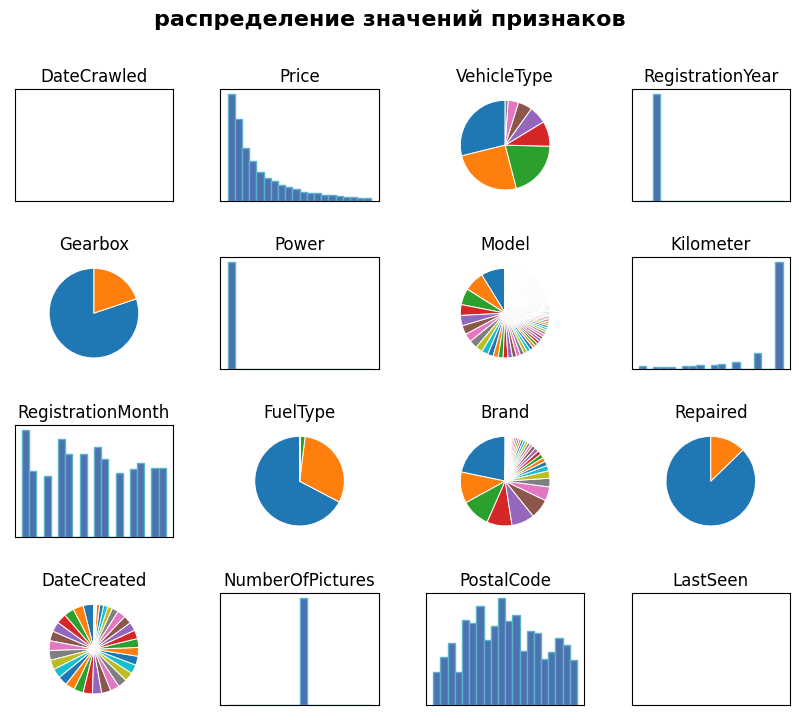

In [6]:
get_info(df)

Предварительно видим такую картинку:
- в датасете 16 признаков и 354369 наблюдений $\Rightarrow$ нужно будет разобраться, все ли они нам нужны
- 7 признаков типа *int* и 9 типа *object* $\Rightarrow$ важно понять, правильный ли тип данных у признаков, а то может кто-то из типа *int* окажется типом *object* или наоборот
- есть явные дубликаты, таких 4 шт. $\Rightarrow$ их удаление не будет критичным
- есть пропуски в значениях $\Rightarrow$ к пропускам будем подходить индивидуально, пытаться понять причины их появления
- названия признаков не в snake_case $\Rightarrow$ исправим

Сохраним в переменную изначальный размер датасета, будем иногда с этим размеров сверяться:

In [7]:
initial_size = df.shape

Приведём названия признаков в к стилю *snake_case*, а сами значения в категориальных признаках приведём в нижнему регистру (вдруг где-то это не так) + удалим явные дублликаты, которых было 4 шт.:

In [8]:
for i, s in enumerate(df.columns):
    s = ''.join(['_' + c.lower() if c.isupper() else c for c in s]).lstrip('_')
    df = df.rename(columns={df.columns[i]: s})
    
df[df.select_dtypes(include=['object']).columns] =\
    df[df.select_dtypes(include=['object']).columns].apply(lambda x: x.str.lower())

df.drop_duplicates(inplace=True)

print(f'теперь дубликатов: {df.duplicated().sum()}')
df.head(2)

теперь дубликатов: 0


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


Теперь пройдёмся по каждому признаку в отдельности и познакомимся с ним поближе:

#### date_created - дата создания анкеты

#### last_seen - дата последней активности пользователя

#### date_crawled - дата скачивания анкеты из базы

рассмотрим даты вместе, изменив формат со str на datetime: 

In [9]:
data_columns = ['date_created', 'last_seen', 'date_crawled']
for i in data_columns:
    get_date_information(df, i)

Признак date_created
минимум: 2014-03-10
максимум: 2016-04-07
уникальных значений: 109

Признак last_seen
минимум: 2016-03-05
максимум: 2016-04-07
уникальных значений: 34

Признак date_crawled
минимум: 2016-03-05
максимум: 2016-04-07
уникальных значений: 34



Наша выборка охватывает довольно точный временной период с 10.03.2014 г. по 07.04.2016 г. - два года. 

В ```date_created``` 109 уникальных значений, а в ```last_seen``` и ```date_crawled``` мы видим 34 дня - это количество уникальных значений, которое остаётся при удалении из признака времени. 

Видим, что компания «Не бит, не крашен» вполне себе серьёзная организация, так как клиентов, судя по количеству объявлений в день, у них довольно много. Интересно было бы узнать, каким образом собираются и хранятся данные, это позволило бы нам сразу обратить внимание на потенциальные огрехи и ошибки в данных. Но пока такой возможности у нас нет, так что все возможные неточности мы продолжим искать самостоятельно. Предварительно отметим только то, что, судя по всему, данные выгружаются из базы не ежедневно.

Для разработки алгоритма, который будет помогать привлекать новых клиентов, конкретно признаки с указанием даты нам, скорее всего, не принесут никакой пользы $\Rightarrow$ удалим из датасета признаки с датой, предусмотрительно отсортировав датафрейм по ```date_created``` и перезаписав индекс:

In [10]:
df = df.sort_values('date_created').reset_index(drop=True)
display(df.head(3), df.tail(3))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-16,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10,0,79669,2016-04-07
1,2016-03-23,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20,0,24558,2016-04-07
2,2016-03-05,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18,0,76275,2016-04-05


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354362,2016-04-07,1890,wagon,2000,manual,150,a4,5000,8,gasoline,audi,no,2016-04-07,0,63065,2016-04-07
354363,2016-04-07,15490,convertible,2010,manual,150,c_reihe,125000,6,gasoline,volvo,no,2016-04-07,0,52076,2016-04-07
354364,2016-04-07,850,sedan,1991,manual,100,3er,30000,10,petrol,bmw,no,2016-04-07,0,81379,2016-04-07


In [11]:
df.drop(columns=data_columns, inplace=True)

#### registration_year - год регистрации автомобиля

#### registration_month - год регистрации автомобиля

Знаем, что признаки года и месяца не содержат пропусков в данных. При этом у нас 151 разных значений лет и 13 месяцев, оригинально) по гистограмме знаем мы и то, что в признаке года все значения сгруппированы где-то в одном месте, а значит остальные могут быть выбросами. Проверим, с какими годами мы имеем дело:

In [12]:
np.sort(df['registration_year'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

1000 год и далее - в объявлениях должны быть какие-то музейные чудо-колесницы, а о 9999 годе и думать страшно. 

Но так как все имеющиеся объявления были опубликованы в конкретное время с 2014-й по 2016-й год, то маловероятно, что в этот временной период в объявления попало что-то действительно экстраординарное, по крайней мере в большом количестве.

Найдём 95%-й доверительный интервал для среднего значения при $\alpha$=5%:

In [13]:
lower_bound, upper_bound = quantile_confidence_interval(df['registration_year'], get_print=True)

Доверительный интервал для среднего значения registration_year: 
	[2003.94, 2004.53]


Уже не так страшно, среднее значение не в средних веках. Постараемся избавиться не только от выбросов и невозможных дат, но и, руководствуясь бизнес-логикой, от крайних и малоэффективных значений с т.зр. количества опубликованных анкет. Посмотрим на распределение анкет по годам:

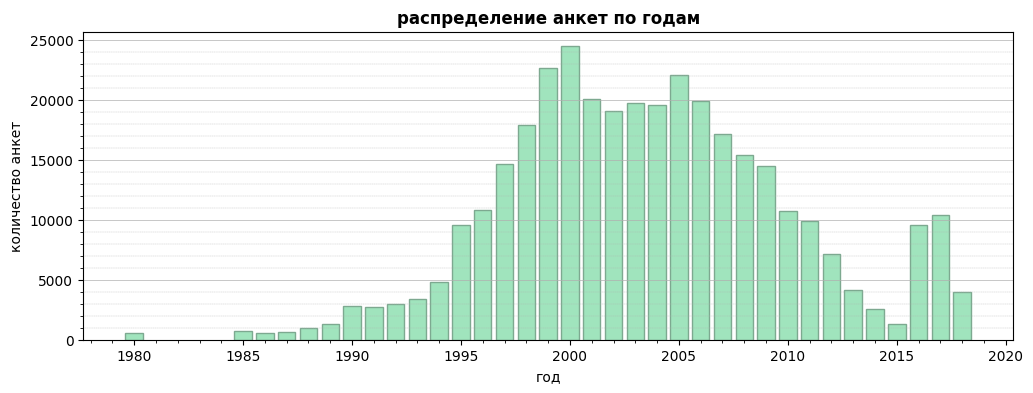

In [14]:
counts = df['registration_year'].value_counts()
inform_list = counts[counts >= 500].sort_index().reset_index()
inform_list.columns = ['year', 'count']

get_bar(inform_list['year'], inform_list['count'], 'год', 'количество анкет', 'распределение анкет по годам')

Что мы видим - в приличном объёме регистрации автомобилей начинаются с 1985-го года. По крайне мере именно с этого года количество размещённых анкет стабильно переваливает за 500 шт. в год. Немного выколотым зубом смотрится 1980-й год. Скорее всего, это связано с тем, что такие "старые" машины зачастую указывают в анкетах без уточнения года, а просто как "зарегистрирована в 80-х". Они для нас тоже важны, так как могут представлять интерес для своего класса покупателей. Объявлений же до 80-х годов довольно мало, их меньше 500-т шт. в год и они не попали в график. Посчитаем их за выбросы и удалим.

Так же на графике видно "всплеск" объявлений в 2016-м и далее годах. Мы не знаем, по какой причине так произошло, возможно, что дело имел какой-то технический сбой при сборе и обработке информации и в нашу исследовательскую выборку попали строки "из будущего", но нам известно то, что крайняя дата среза информации - это самое начало апреля 2016-го года. 

Соответственно, всем публикациям, размещённым после этой даты, доверять нельзя $\Rightarrow$ обрежем данные до апреля 2016-го года.

А что по месяцам? Посмотрим, почему у нас там 13 уникальных значений и сколько анкет приходится на каждый месяц:

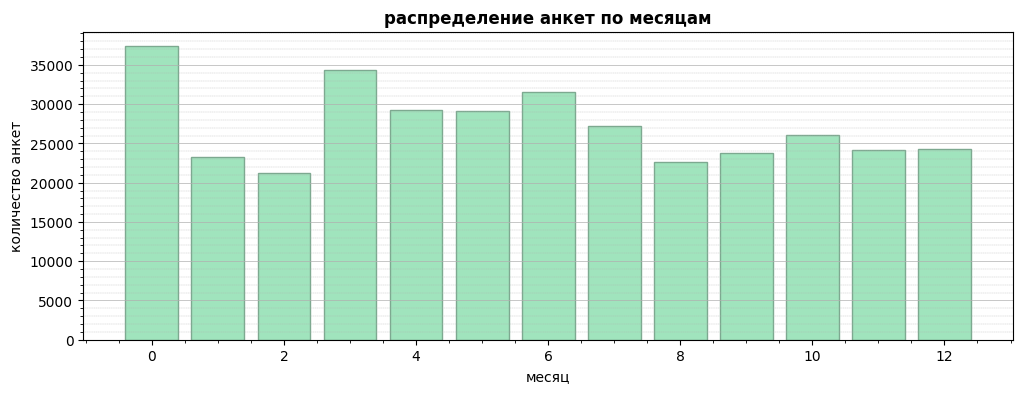

In [15]:
inform_list = df['registration_month'].value_counts().sort_index().reset_index()
inform_list.columns = ['month', 'count']
get_bar(inform_list['month'], inform_list['count'], 'месяц', 'количество анкет', 'распределение анкет по месяцам')

Вот и выяснилась природа 13-го месяца - это месяц под номером 0. Скорее всего, ноль может являться условным обозначением пропуска в данных. Проверим, на какие года приходится месяц 0:

In [16]:
np.sort(df.loc[df['registration_month'] == 0, 'registration_year'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1500, 1600,
       1602, 1688, 1800, 1910, 1923, 1928, 1930, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1941, 1942, 1947, 1948, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1958, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2222,
       2290, 2500, 2800, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 5000,
       5300, 5555, 5600, 5900, 5911, 6000, 7000, 7500, 7800, 8000, 8500,
       8888, 9000, 9229, 9450, 9996, 9999], dtype=int64)

На все подряд года... Так как у нас нет полной уверенности в том, что 0 - это обозначение пропуска в данных, мы не рискнём заменять 0 какими-либо другими значениями, но будем помнить о том, что природу его появления неплохо было бы в дальнейшем уточнить у компании «Не бит, не крашен». 

А пока посмотрим ещё раз на график и увидим, что из нормальных месяцев 3-й месяц - март - имеет самое большое количество анкет. Это для нас важно, так как наши данные скачаны по 7-е апреля 2016-го, на 7-е же апреля приходятся даты последних активностей в анкетах. Апрель 2016-го у нас захвачен всего на неделю, а вот март полный $\Rightarrow$ оставим себе данные с 1980-го года по март 2016-го включительно. Создадим из года и месяца отдельный столбец с датой и по нему отфильтруемся. Это не самая простая задача, так как у нас много безобразных дат с недопустимыми для создания Timestamp-формата диапазонами. Но так как после анализа данных мы этот столбец всё равно удалим, то сохранность `registration_date` и `registration_month` для нас не принципиальна:

In [17]:
df['registration_month'] = df['registration_month'].replace(0, 1)              # убираем нули
df = df[(df['registration_year'] >= 1900) & (df['registration_year'] <= 2100)] # убираем края дат
df['registration_date'] = (pd.to_datetime(df['registration_year'].astype(str) + 
                                          '-' + df['registration_month'].astype(str) + '-1', errors='coerce'))
df = df[(df['registration_date'] >= '1980-01-01') & (df['registration_date'] <= '2016-03-31')]

Дело сделано. Удалим теперь столбцы с датами ```registration_month``` и ```registration_date``` (временно оставим только ```registration_year```, он на ещё пригодится):

In [18]:
df.drop(columns=['registration_month', 'registration_date'], axis=1, inplace=True)

Проверим, не много ли мы удалили данных к этому моменту:

In [19]:
f'{1-df.shape[0] / initial_size[0]:.2%}'

'6.59%'

6.5%, не криминально. При этом мы явно отбросили анкеты с невозможными датами, слишком старыми датами и датами из будущего. 

#### number_of_pictures - количество фотографий автомобиля

Этот признак совсем неинформативен и не содержит никаких значений кроме нуля, разговор с ним короткий - удаляем

In [20]:
df.drop(columns='number_of_pictures', inplace=True)

#### postal_code - почтовый индекс владельца анкеты (пользователя)

Признак содержит 8143 оригинальных значения, он типа int, хотя, очевидно то, что отнести его следует к категориальным признакам. Почтовый индекс владельца анкеты - важный параметр, так как он может содержать информацию о географическом расположении клиента, а география, в свою очередь, может быть связана с ценой автомобиля. Ведь некоторые районы могут быть более дорогими и иметь высокие цены на авто.

Проведём небольшое исследование 🔍 самую малость погуглив мы можем убедиться в том, что имеющиеся в нашем распоряжении индексы - это индексы Германии:

In [21]:
df['postal_code'].value_counts().index[:5]

Int64Index([10115, 65428, 66333, 44145, 32257], dtype='int64')

Всё 8143 значения столбца - это цифры разрядности 4 или 5:

In [22]:
print(
    f"разрядность индексов:\n\t{df['postal_code'].astype(str).str.len().value_counts(normalize=False).index}\n"
    f"индексы начинаются с цифр:\n\t{df['postal_code'].astype(str).str.slice(start=0, stop=1).value_counts(normalize=False).index}"
)

разрядность индексов:
	Int64Index([5, 4], dtype='int64')
индексы начинаются с цифр:
	Index(['4', '5', '3', '2', '6', '8', '7', '1', '9'], dtype='object')


Причём значений с 4-й разрядностью гораздо меньше, чем с 5-й, оно и не удивительно, ведь причина меньшей разрядности в потерянном нуле в самом начале числа, так как мы имеем дело не просто с какими-то там абстрактными индексами, а системой ```PLZ``` (нем. Postleitzahl) — современной системой почтовых индексов Германии. О системе организации почтовой индексации в Германии можно почитать в [Википедии](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%87%D1%82%D0%BE%D0%B2%D1%8B%D0%B5_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D1%8B_%D0%B2_%D0%93%D0%B5%D1%80%D0%BC%D0%B0%D0%BD%D0%B8%D0%B8) или на сайте [auto.germany.ru](http://auto.germany.ru/map.html)

![plz_germany.md.png](https://ltdfoto.ru/images/2023/06/08/plz_germany.md.png)

Зная всё, что мы теперь знаем, переведём имеющиеся у нас индексы в строки номера земель от 0 до 9-ти:

In [23]:
def restore_index(ind):
    if len(ind) == 4:
        ind = '0'
    return int(ind[0])
    
df['postal_code'] = df['postal_code'].apply(lambda x: restore_index(str(x)))

In [24]:
plz_dict = {0: 'Саксония', 1: 'Берлин', 2: 'Гамбург', 3: 'Нижн.Саксония',
            4: 'с-з Сев.Рейн', 5: 'ю-з Сев.Рейн', 6: 'Гессен', 
            7: 'Баден', 8: 'южн. Бавария', 9: 'сев. Бавария'}

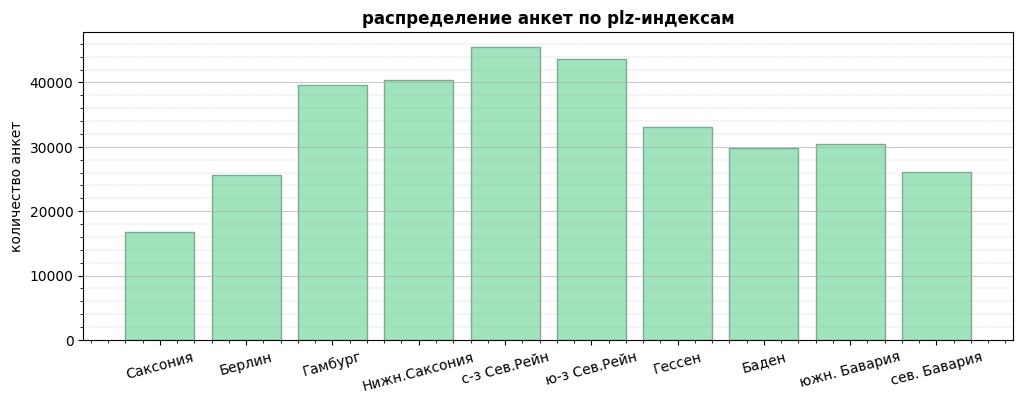

In [25]:
inform_list = df['postal_code'].value_counts().sort_index().reset_index()
inform_list.columns = ['plz_index', 'count']
get_bar([plz_dict.get(i, i) for i in inform_list['plz_index']]
        , inform_list['count'], '', 'количество анкет', 'распределение анкет по plz-индексам', rotation=15)

Вот так уже вполне наглядно мы можем видеть то, что основная клиентская база компании «Не бит, не крашен» сосредоточена в западных землях Германии, бывшая же ГДР проседает. Причин тому может быть много, но не в последнюю очередь особенность такого распределения объясняется и историческим укладом бизнес-активности в Германии - запад страны коммерчески успешнее и предложений по продаже автомобилей там предсказуемо больше.

А компании «Не бит, не крашен» для привлечения клиентов первым делом стоит, пожалуй, не модели разрабатывать, а изменить название на что-то более звучное немецкому уху, ну например «Nicht kaputt, nicht lackiert»))

Итак, с датами и землями разобрались, переходим непосредственно к характеристикам авто.

#### brand - марка автомобиля

Признак содержит 40 уникальных значений и не имеет пропусков:

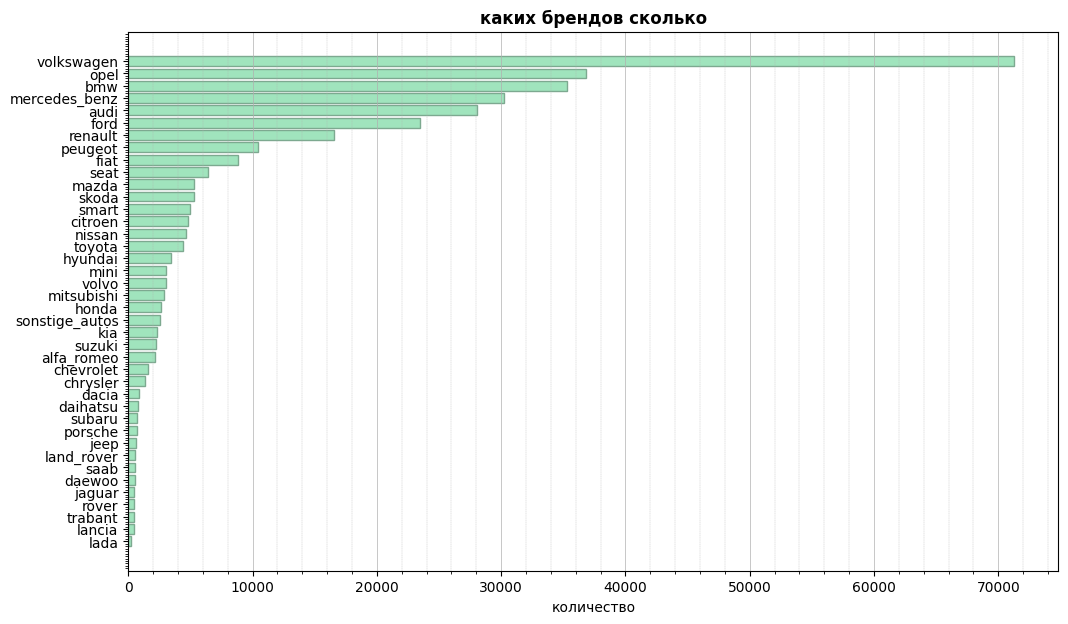

In [26]:
inform_list = df['brand'].value_counts().sort_index().reset_index()
inform_list.columns = ['brand', 'count']
inform_list = inform_list.sort_values('count')
get_bar(inform_list['brand'], inform_list['count'], 'количество', '', 'каких брендов сколько', h=True)

Посмотрим, в каких землях какие марки машин предпочитают:

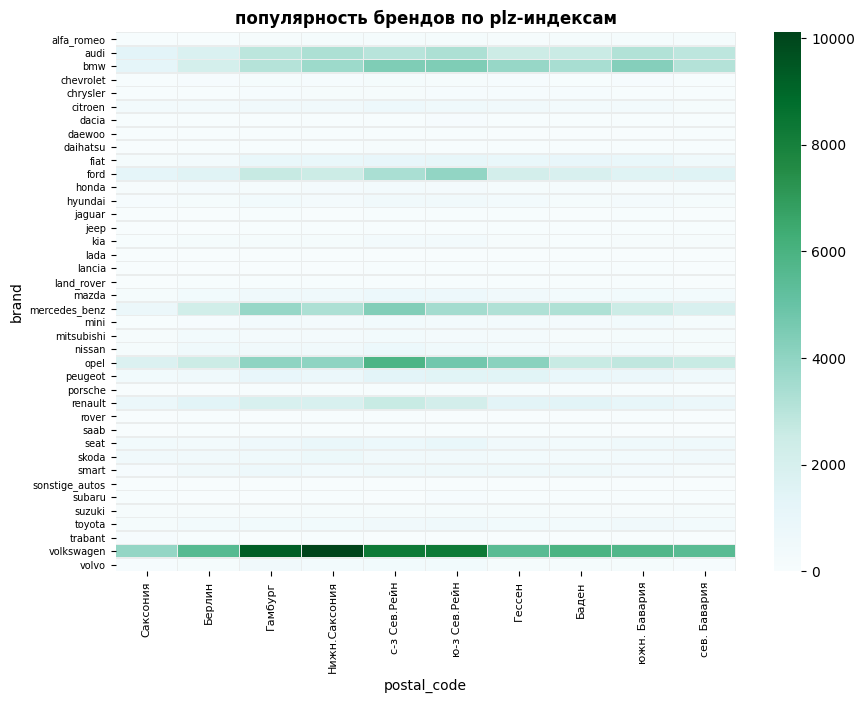

In [27]:
get_heatmap(df, 'brand', 'postal_code', 'model', 'популярность брендов по plz-индексам')    

| Марка автомобиля | Принадлежность | Штаб-квартира | Регион (plz-индекс) |
| --- | --- | --- | --- |
| [Volkswagen](https://ru.wikipedia.org/wiki/Volkswagen) | Volkswagen AG | Вольфсбург, Нижняя Саксония | 3 |
| [Opel](https://ru.wikipedia.org/wiki/Opel) | General Motors | Рюссельсхайм, Гессен | 6 |
| [BMW](https://ru.wikipedia.org/wiki/BMW) | BMW AG | Мюнхен, Южная Бавария | 8 |
| [Audi](https://ru.wikipedia.org/wiki/Audi) | Volkswagen AG | Ингольштадт, Южная Бавария | 8 |
| [Mercedes-Benz](https://ru.wikipedia.org/wiki/Mercedes-Benz) | Mercedes-Benz Group | Штутгарт, Баден-Вюртемберг | 7 |
| [Ford](https://ru.wikipedia.org/wiki/Ford) | Ford Motor Company | Кёльн, Северный Рейн-Вестфалия | 5 |

Видим, что абсолютными хитами по всей стране являются: 
- ```немецкий Volkswagen``` - он в безусловных лидерах по всей Германии, марка принадлежит немецкому концерну Volkswagen AG, это город Вольфсбург, Нижяя Саксония, plz-индекс региона 3. Неудивительно, что там он №1
- ```немецкий Opel``` - принадлежит американскому концерну General Motors, штаб-квартира и производство в городе Рюссельсхайм, Гессен, plz-индекс региона 6
- ```немецкий BMW``` - сами по себе, штаб-квартира в Мюнхене, plz-индекс региона 8 (Южная Бавария)
- ```немецкий Audi``` -  принадлежит немецкому концерну Volkswagen AG, а штаб-квартира в Ингольштадте, это тоже Южная Бавария с plz-индексом региона 8
- ```немецкий Mercedes-Benz``` - принадлежит немецкому концерну Mercedes-Benz Group, город Штутгарт, земля Баден-Вюртемберг, plz-индекс региона 7
- ```американский Ford``` - что неудивительно, так как Ford - четвёртый в мире производитель автомобилей по объёму выпуска, они везде и всюду. Да и собирают их в Кёльне, земля Северный Рейн-Вестфалия, plz-индекс региона 5

Очевидно, немецкий автолюбитель предпочитает отечественные бренды. Эти же бренды перешагнули порог в 20000 в количестве размещённых анкет в исследуемом нами периоде от компании «Не бит, не крашен», на них, вне всякого сомнения, нужно делать основной маркетинговый упор.

#### model - модель автомобиля

Вот здесь начинаются дыры в данных, признак ```model``` содержит 251 оригинальное значение и после отрезания некорректных временных периодов 16101 пропуск в данных:

In [28]:
print(f'пропусков {df.isna().sum().model}, это {df.isna().sum().model / df.notnull().sum().model:.2%}')

пропусков 16101, это 5.11%


Посмотрим, для каких марок автомобилей есть пропуски 

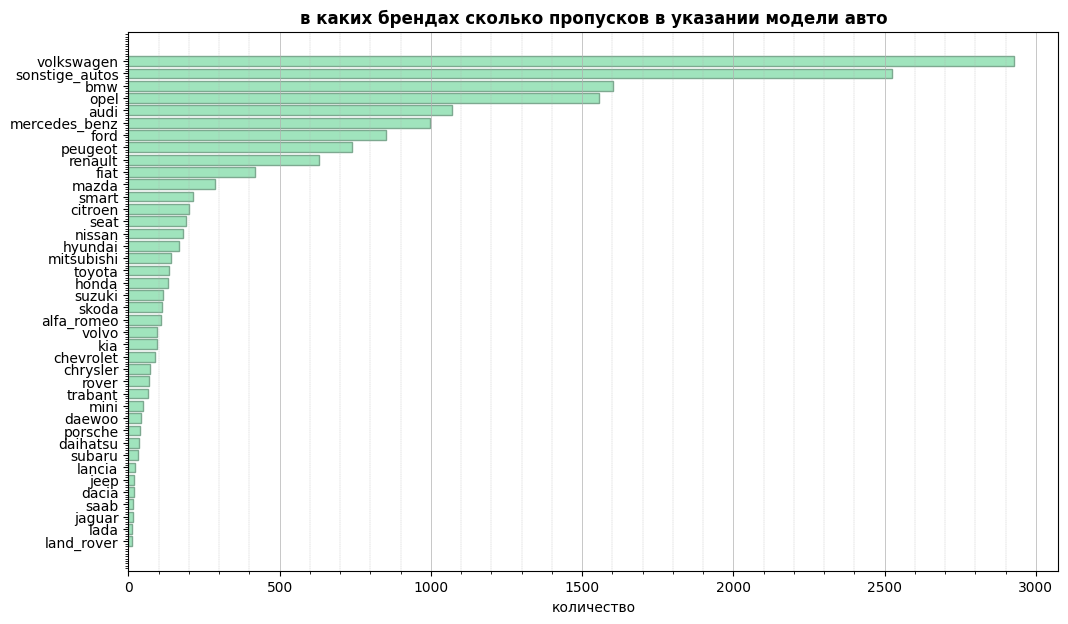

In [29]:
number_of_null = (
    df.groupby('brand')['model']
    .apply(lambda x: x.isna().sum())
    .reset_index(name='кол-во пропусков')
    .sort_values('кол-во пропусков')
)
get_bar(number_of_null['brand'], number_of_null['кол-во пропусков'], 
        'количество', '', 'в каких брендах сколько пропусков в указании модели авто', h=True)

По графику видим, что пропуски в названии модели авто по брендам в своих пропорциях очень похожи на количество этих брендов вообще. Исключением может показаться ```sonstige_autos```, но это на немецком означает *другие автомобили* и с ними своя история - в них бренды не указаны в принципе:

In [30]:
(
    df.groupby('brand')['model']
    .apply(lambda x: x.notnull().sum())
    .reset_index(name='кол-во значений')
    .sort_values('кол-во значений').head(3)
)

,brand,кол-во значений
33,sonstige_autos,0
16,lada,178
28,rover,373


Удалим их, так как мы не знаем про них ни марку ни модель:

In [31]:
df = df[df['brand'] != 'sonstige_autos']

В остальном мы видим некую закономерность и стабильную последовательность в наличии пропусков, общее количество которых в разбивке на бренды не так велико. Это не похоже на какие-то технические сбои, возникающие при выгрузке базы, скорее это похоже на то, что порядка 5% пользователей не заморачивается и не указывает модель автомобиля в анкете. А значит вряд ли они пришли на сайт с каким-то действительно уникальным предложением, вероятнее всего у них что-то как у всех, что-то популярное и легкоузнаваемое.

$\Rightarrow$ заполним пропуски модой, но для бóльшей точности сгруппируем моду не только по бренду, но и по plz-индексаем, там бы получим десятикратную точность "попадания" в популярную для своего региона модель:

In [32]:
grouped = df.groupby(['brand', 'postal_code'])
df = grouped.apply(fill_mode, column_name='model')

Сверимся, не много ли мы удалили к этому моменту:

In [33]:
f'{1-df.shape[0] / initial_size[0]:.2%}'

'7.30%'

Совсем немного, можем спокойно двигаться дальше.

#### vehicle_type - тип автомобильного кузова

#### gearbox - тип коробки передач

#### fuel_type - тип топлива

Все эти 3 признака относятся к техническим характеристикам автомобилей и во всех трёх от 5% пропусков:

In [34]:
df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].isna().sum()

vehicle_type    16483
gearbox         15908
fuel_type       23608
dtype: int64

In [35]:
isna_ = df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].isna().sum()
notnull_ = df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].notnull().sum()
print(f"% пропусков:\n{np.round((isna_ / notnull_)*100, 2)}")

% пропусков:
vehicle_type    5.28
gearbox         5.09
fuel_type       7.74
dtype: float64


При это мы помним о том, что уникальных значений для типов кузова 9, для коробки передач 3, а для топлива 8, так как признаки категориальные.

Причина пропусков, скорее всего, заключается в том, что данные признаки не являются обязательными при  составлении анкет пользователями. Но они действительно важны, так как напрямую влияют на формирование цены автомобиля. Посмотрим, много ли таких предложений, для которых отсутствует информация по всем трём признакам:

In [36]:
df[(df['vehicle_type'].isnull()) & (df['gearbox'].isnull()) & (df['fuel_type'].isnull())].shape[0]

4929

Такие автопредложения слишком малоинформативны и, отталкиваясь от характеристик других признаков для заполнения отсутствующих значений, мы рискуем нагородить ерунды $\Rightarrow$ удалим их: 

In [37]:
df = df[~((df['vehicle_type'].isnull()) & (df['gearbox'].isnull()) & (df['fuel_type'].isnull()))]

Проверим, сколько мы уже наудаляли к этому времени от изначального размера данных:

In [38]:
f'{1-df.shape[0] / initial_size[0]:.2%}'

'8.69%'

А пропусков осталось:

In [39]:
isna_ = df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].isna().sum()
notnull_ = df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].notnull().sum()
print(f"% пропусков:\n{np.round((isna_ / notnull_)*100, 2)}")

% пропусков:
vehicle_type    3.70
gearbox         3.51
fuel_type       6.13
dtype: float64


Посмотрим на распределение значений:

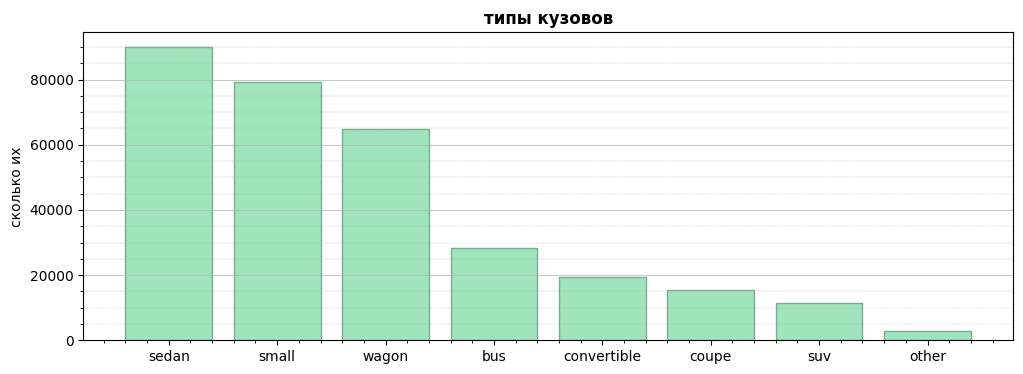

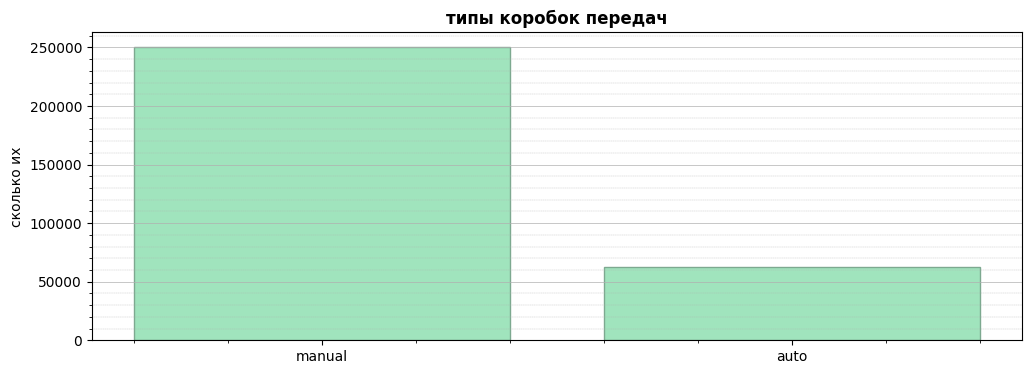

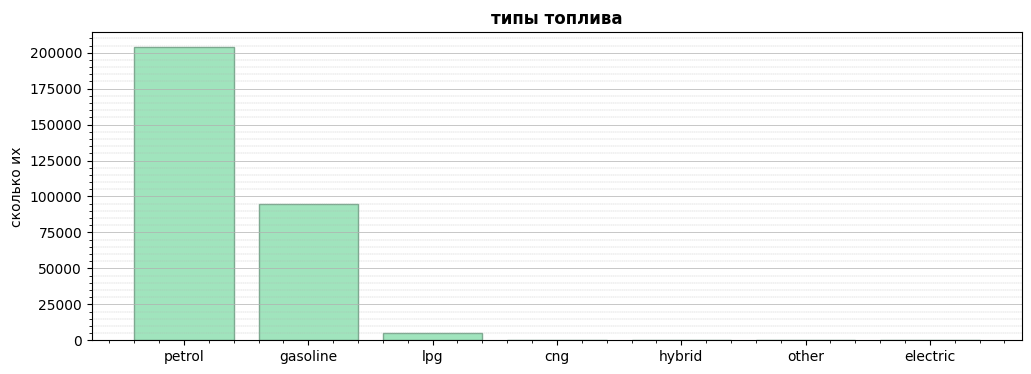

In [40]:
categories = [('vehicle_type', 'типы кузовов'),
              ('gearbox', 'типы коробок передач'),
              ('fuel_type', 'типы топлива')]
for i in categories:
    counts = df[i[0]].value_counts()
    get_bar(counts.index, counts.values, '', 'сколько их', i[1])

Типы данных выглядят адекватно и соответстсвуют своему направлению. Поступим с пропусками в них так же, как ранее поступали с пропусками моделей авто - заполним модой по группировке признаков - *brand* и *model*, так как совпадение технических характеристик для пары бренд-модель по популярным маркам автомобилей должно быть довольно точным:

In [41]:
for col_name in ['vehicle_type', 'gearbox', 'fuel_type']:
    grouped = df.groupby(['brand', 'model'])
    df = grouped.apply(fill_mode, column_name=col_name)
    # один какой-то признак всё же остаётся, снесём его вручную
    if df[df.vehicle_type.isna()].shape[0]:
        df = df[~df.vehicle_type.isnull()]

#### power - мощность (л. с.)

Признак содержит 712 оригинальных значений и не содержит пропусков, но у него слишком сильный разлёт этих самых значений. Посмотрим на минимальные и максимальные из них:

In [42]:
df['power'].value_counts().sort_index()

0        28719
1           20
2            8
3            1
4            6
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 682, dtype: int64

А вот и странности проявились - в распределении есть нули и какие-то совсем уж огромные значения. Посмотрим, с чем имеем дело, на графике:

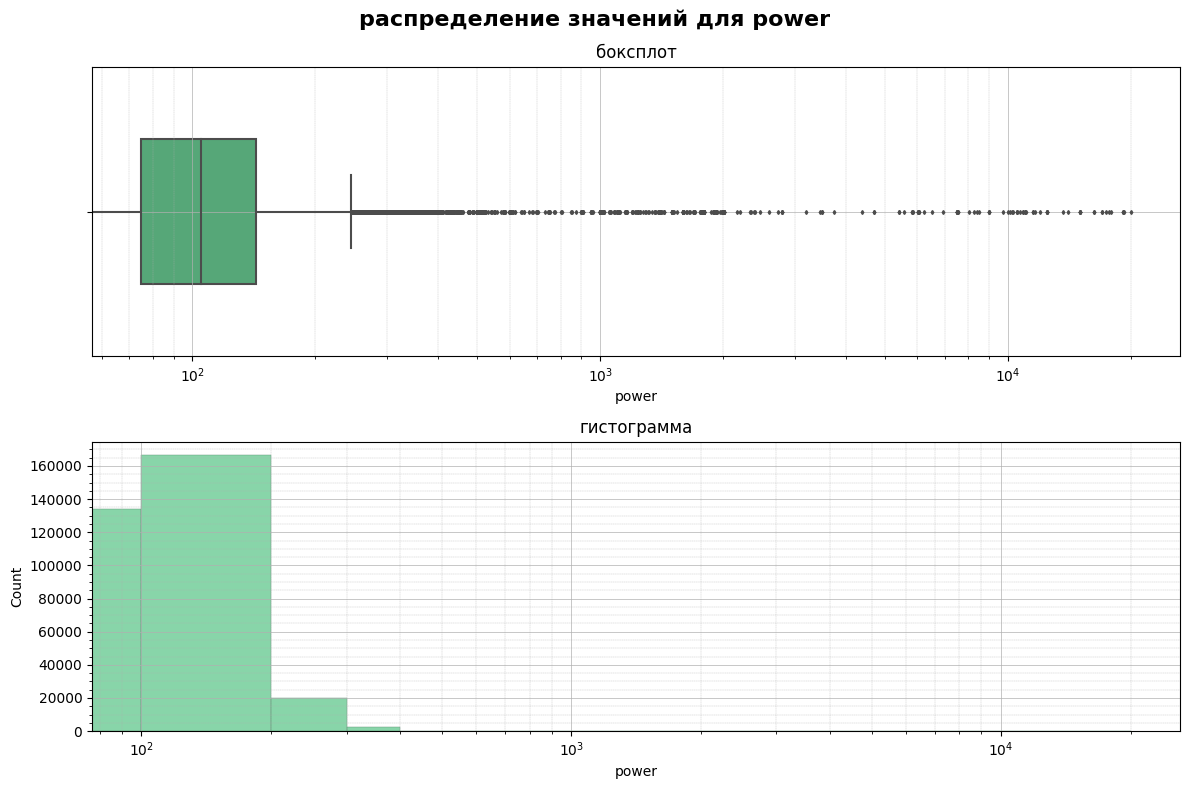

In [43]:
get_distribution_of_values(df['power'], log_scale=True)

Для того, чтобы на графиках разглядеть хоть что-то, пришлось применять к ним логарифмический масштаб, настолько большие выбросы значений в них есть. И если нулевое значение ещё можно объяснить, оно, скорее всего, определяет отсутствие какой-либо информации в принципе, аналог NaN, то хвост вправо пугающе большой. Будем его удялять.

Для того, чтоб корректно определить размер выбросов, необходимо погрузиться чуть глубже в понимание того, что есть лошадиная сила. Этот параметр довольно трудно интерпретировать на сегодняшний день, так как он, во-первых, считается устаревшим и, во-вторых, в разных странах под понятие "Лошадиная сила" подпадают совершенно разные технические характеристики. В-третьих же, при попытке нагуглить что-то вразумительное страницы поиска заполняются бесконечными рекламами одноимённых средств по уходу за волосами)) Но вот есть русскоязычная статья в [Википедии](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D1%88%D0%B0%D0%B4%D0%B8%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D0%BB%D0%B0), она, как это часто бывает, довольно исчерпывающе разъясняет это понятие. А вот уже из англоязычной википедии [таблица](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output) хронологии самых мощных серийных автомобилей. Возьмём себе из неё рассматриваемый нами период с 1980-го по 2016-й года:

In [44]:
url = 'https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output'
table_df = pd.read_html(url)[2]

table_df['Year'] = table_df['Year'].apply(lambda year_str: int(year_str[:4]))
table_df[(table_df['Year'] >= 1980) & (table_df['Year'] <= 2016)]

,Vehicle,Year,Power,Notes,Sources
16,Bugatti EB110,1991,412 kW (553 hp; 560 PS),139 produced.,[65]
17,McLaren F1,1992,461 kW (618 hp; 627 PS),106 produced. Remained most powerful car for 12 years (including the LM).,[66]
18,McLaren F1 LM,1995,500 kW (671 hp; 680 PS),6 produced including the prototype.,[67][68]
19,Koenigsegg CCR,2004,601 kW (806 hp; 817 PS),14 produced.,[46][47]
20,Bugatti Veyron,2005,"736 kW (987 hp; 1,001 PS)",310 produced (16.4 and Grand Sport). First car with a double-clutch transmission on list.,[69][23]
21,SSC Ultimate Aero TT,2009,"960 kW (1,287 hp; 1,305 PS)",Last car with a manual transmission on list.,[70]
22,Koenigsegg One:1,2014,"1,000 kW (1,341 hp; 1,360 PS)",7 produced.,[71]
23,Koenigsegg Regera,2016,"1,119 kW (1,500 hp; 1,521 PS)",80 units produced. First hybrid car on list.,[72]


Нас интересует параметр **PS** (от немецкого "*pferdestärke*" - лошадиные силы). По таблице мы видим, что действительно мощных машин в мире не так-то и много, согласно Википедии на 2016-й год самой мощной была заявлена [Koenigsegg Regera](https://ru.wikipedia.org/wiki/Koenigsegg_Regera), но она нам даже не подходит, так как фактически выпущена была только в 2017-м году (80 экземпляров). Оставшихся с 1991-го года "мощных" кандидатов можно по пальцам рук пересчитать. 

$\Rightarrow$ даже если в наших данных и есть небольшое количество действительно эксклюзивных предложений скоростных авто, по лошадиным силам на начало 2016-го года они никак не могут быть выше существовавшего скоростного порога. Причину наличия в базе таких "странных" значений своими силами мы объяснить не сможем, оставим этот вопрос до уточнения у компетентных сотрудников компании «Не бит, не крашен», а пока удалим из базы аномальные строки и посмотрим ещё раз на графиках на распределение, но уже без логарифмического масштаба:

In [45]:
df = filtering_outliers_by_quantiles(df, 'power')

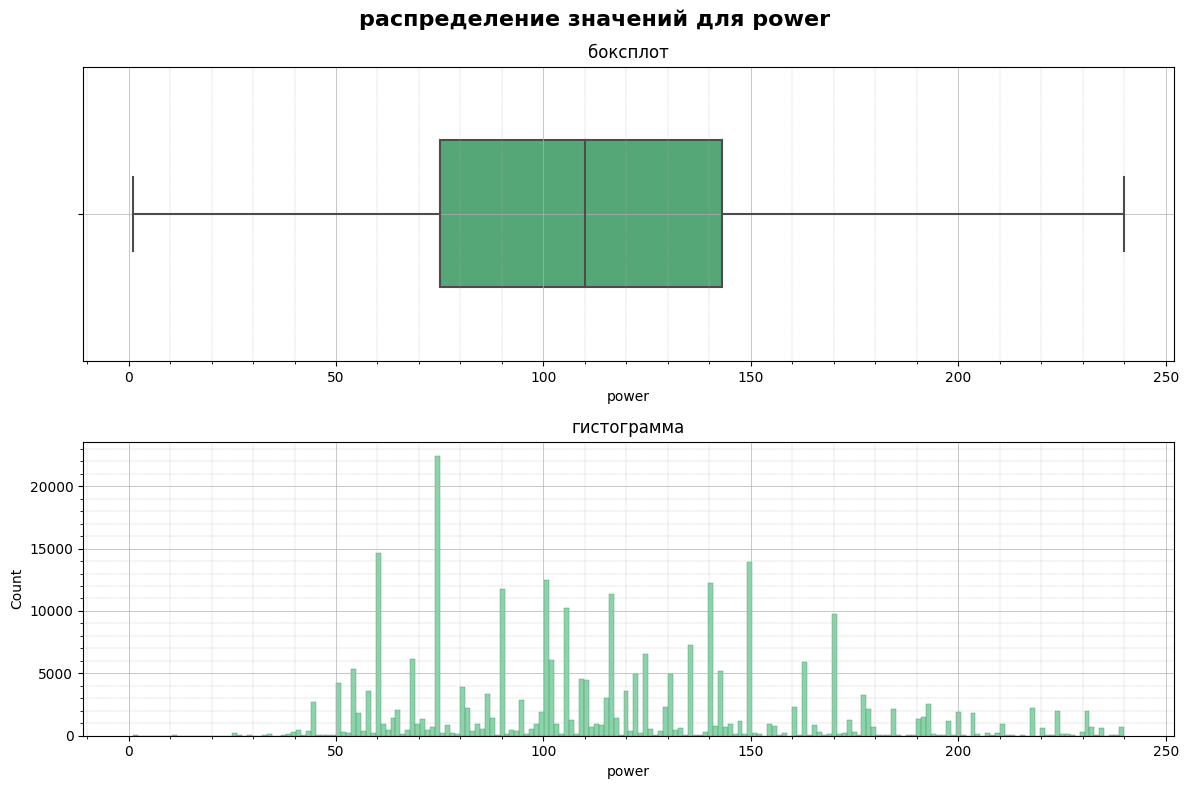

In [46]:
get_distribution_of_values(df['power'])

Совсем другой разговор. Посмотритм, сколько всего мы отрезали данных к этому времени:

In [47]:
f'{1-df.shape[0] / initial_size[0]:.2%}'

'19.11%'

Многовато, но, с другой стороны, мы убрали всякие странности, которые ML-моделям могли бы мешать.

#### kilometer - пробег (км)

Изначально в признаке не было пропусков, при этом было довольно мало оригинальных значений, посмотрим, как дело обстоит сейчас:

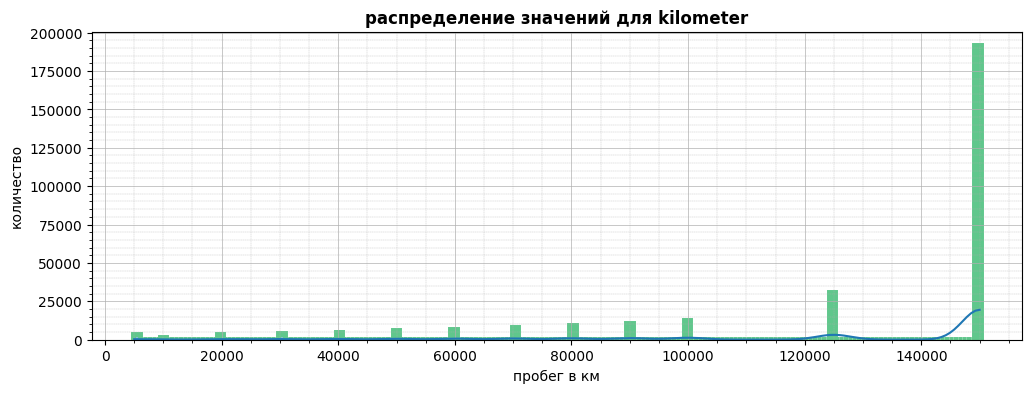

In [48]:
get_sns_histplot(df['kilometer'], 'пробег в км')

Основные значения как-то скучковались в одном углу. И судя по их небольшому количеству, мы можем предположить, что информация о пробеге в анкетах, во-первых, является обязательной к заполнению (пропусков нет), а во-вторых, не предполагает произвольного ввода цифр. В основном цифры пробега довольно большие, но так и сервис-то у нас по размещению объявлений о продаже автомобилей от частных лиц, т.е. преимущественно б/у-автомобилей, но и подобный пробег в предложениях может быть вполне допустимым.

Вот есть хорошая [статья](https://maximum-auto.ru/blog/normalniy-probeg-bu-avto/) о том, из чего складывается цена и как на неё влияет в том числе пробег и в том числе, кстати, пробег немецких б/у-автомобилей. Конечно, статья написана для русского покупателя, но она подчёркивает и то, что: 
- немецкий автолюбитель бережлив
- для машины пробег 150000 км. далеко не предел, но всё же это уже некая планка, указывающая на то, что хоть автомобиль и не бит и не крашен, однако поколесить по европейским дорогам успел.

Для того, чтобы убедиться в том, что в наших данных значение пробега - это не рандомно заполненный столбец, посмотрим на то, как зависят друг от друга цена на авто в объявлениях и пробег:

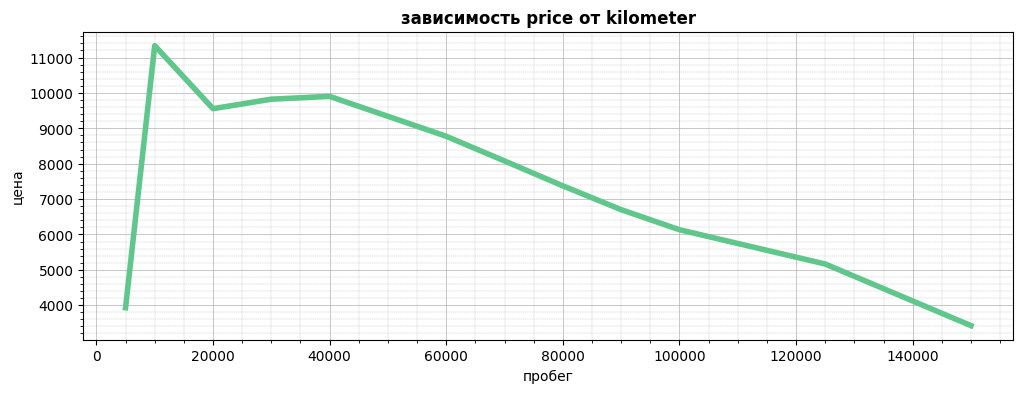

In [49]:
get_lineplot(df, 'kilometer', 'price', 'пробег', 'цена')

Зависимость очевидна - с ростом пробега цена снижается, а значит значения в признаке kilometer осмысленны и как-то дополнительно трансформировать их нет смысла, оставим как есть.

#### repaired - была машина в ремонте или нет

Признак с огромным количеством пропусков и всего тремя значениями, посмотрим на него:

In [50]:
print(f"пропусков {df['repaired'].isna().sum()}\nзначения:\n{df['repaired'].value_counts()}")

пропусков 41656
значения:
no     216078
yes     28902
Name: repaired, dtype: int64


Видим, что признак бинарный, третьим значением в нём определялись пропуски. Исходя из проведённого выше исследования причина, по которой эти пропуски появились в данных, напрашивается сама собой - многие пользователи при заполнении анкет просто не указывают этот параметр, так как он, конечно же, может существенно влиять на скорость продажи автомобиля и его цену, ведь никто не хочет покупать битую машину за дорого))
Посмотрим, сколько в % занимают анкеты в пропуском в ```repaired```:

In [51]:
f"{(df['repaired'].isna().sum()  / df.shape[0]):.2%}"

'14.53%'

14.5% - это много для удаления из-за буквально одного параметра, когда мы знаем наверняка, что анкеты с неотмеченной информацией о ремонте не фейк. Но из мудрого жизненного опыта мы догадываемся так же и о том, что данный параметр может существенно влиять на релевантность анкеты $\Rightarrow$ заполнять признак как *yes* или *no* не будем, но заполним его как третье значение - *not_filled*:

In [52]:
df['repaired'].fillna('not_filled', inplace=True)

#### price — цена (евро)

Это целевая переменная, её будем предсказывать. Пропусков в ней нет, а есть ли нули? Проверим:

In [53]:
df['price'].value_counts().sort_index().head(20)

0     5793
1      561
2        6
3        4
5        7
9        4
10      20
11       1
12       1
13       2
15       3
16       1
20       6
24       1
25       4
29       1
30      10
35       3
38       1
39       3
Name: price, dtype: int64

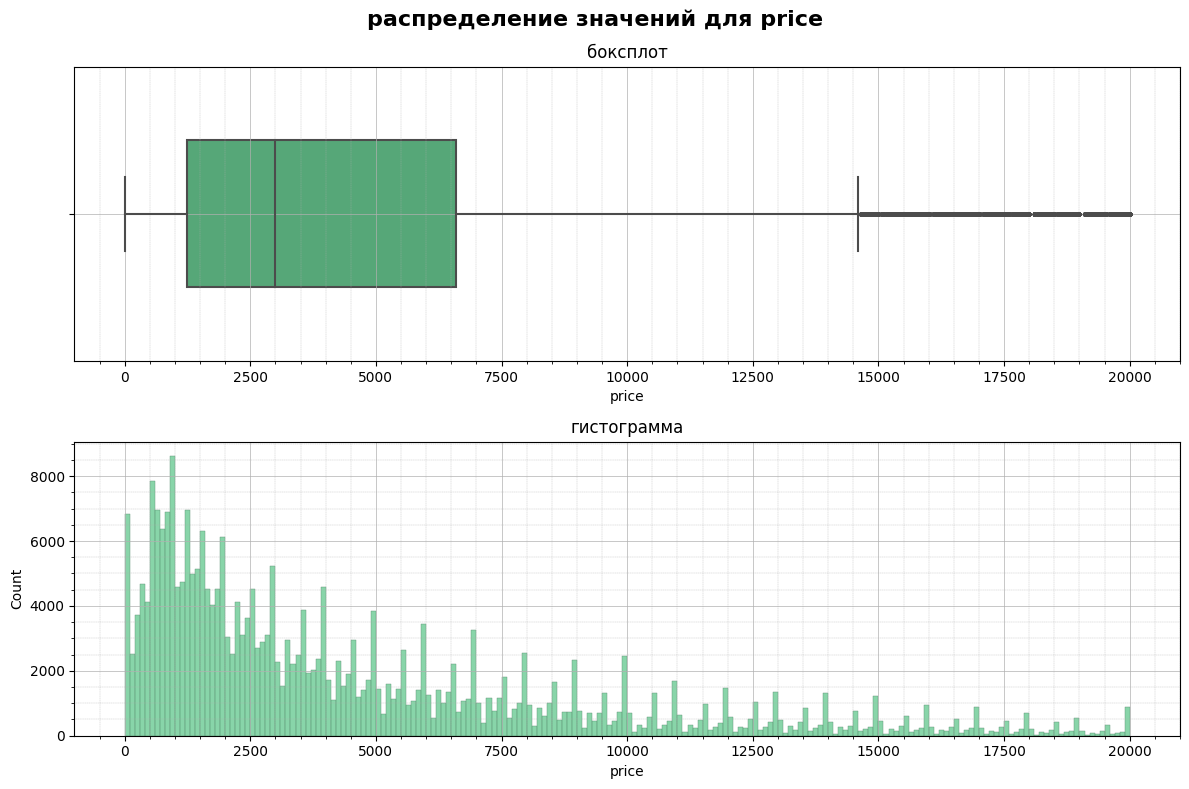

In [54]:
get_distribution_of_values(df['price'])

Есть нули. В реальной жизни они, скорее всего, означают объявления, на котрые не указали цену. Много и таких объявлений, для котрых указана невозможная цена типа 5-6 евро. Точно разъяснить причину такого "ценообразования" помогло бы непосредственное знакомство с порталом объявлений, но у нас к нему нет доступа.

Допустим невозможное и предположим, что цена до 100 существует в этом мире. Проверим, много ли у нас таких объявлений:

In [55]:
print(f"объявлений дешевле 100 евро {df[df['price'] < 100].shape[0]} шт., "
      f"это {df[df['price'] < 100].shape[0]/df.shape[0]:.2%}")

объявлений дешевле 100 евро 6837 шт., это 2.39%


Почти 7 тысяч объявлений или меньше 2.5% об общего количества - это объявления с неприлично низкой ценой или отсутствующей ценой вовсе. И даже если такие цены существуют, мы должны помнить о том, что разрабатываем алгоритм, который должен предлагать цену автору анкеты, клиенту сервиса. Продавай клиент даже ведро с болтами, ему было бы неприятно узнать о том, что его дорогую сердцу "ласточку" оценили в 12 евро, с точки зрения бизнес-логики это некорректно $\Rightarrow$ обрежем минимальный хвост по ценам, чтоб модель не обучалась таких минимумуах:

In [56]:
df = df[df['price'] >= 100]

#### генерация новых признаков

Признаки разобрали, порверим теперь, сколько значений у нас осталось после удаления всех неточностей и аномалий:

In [57]:
print(df.info())
f'{df.shape[0] / initial_size[0]:.2%}'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279799 entries, 1 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              279799 non-null  int64 
 1   vehicle_type       279799 non-null  object
 2   registration_year  279799 non-null  int64 
 3   gearbox            279799 non-null  object
 4   power              279799 non-null  int64 
 5   model              279799 non-null  object
 6   kilometer          279799 non-null  int64 
 7   fuel_type          279799 non-null  object
 8   brand              279799 non-null  object
 9   repaired           279799 non-null  object
 10  postal_code        279799 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.6+ MB
None


'78.96%'

79% от изначального количества наблюдений и 9 признаков. Компенсируем потери генерацией новых признаков:

In [58]:
# возраст автомобиля:
df['age'] = 2016 - df['registration_year']

# индекс популярности бренда:
brand_counts = df['brand'].value_counts()
df['brand_popularity_index'] = df['brand'].apply(lambda x: brand_counts[x])

# производительность двигателя на единицу массы:
df['hp_per_kg'] = (df['power'] / (df['kilometer'] / 1000)).round(3)

# пробег в год:
df['mileage_per_year'] = (df['kilometer'] / df['age']) 
df.loc[df['mileage_per_year'] == np.inf, 'mileage_per_year'] = 1
df['mileage_per_year'] = df['mileage_per_year'].astype(int)

И напоследок - удаляем год постановки на учёт ```registration_year```, он нам помог с генерацией новых признаков и больше не нужен:

In [59]:
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code,age,brand_popularity_index,hp_per_kg,mileage_per_year
1,6000,bus,1995,auto,200,other,150000,petrol,chevrolet,no,2,21,1280,1.333,7142
3,14250,convertible,2005,manual,163,slk,150000,petrol,mercedes_benz,no,7,11,24846,1.087,13636
4,5200,convertible,2006,manual,109,2_reihe,80000,petrol,peugeot,no,2,10,9231,1.362,8000


In [60]:
df.drop(columns='registration_year', axis=1, inplace=True)

### Предварительный вывод. На данном этапе мы:

- загрузили данные, необходимые для дальнейшего машинного обучения
- детально разобрали каждый признак, порезали-почистили-выверили некоторые значения
- обнаружили много странного в предоставленных данных, некоторые моменты требуют компетентного комментария опытных специалистов компании «Не бит, не крашен», а именно:
  - наличие пропусков в данных
  - присутствие невозможных значений типа 1000-го года регистрации авто или 20000 лошадиных сил
  - проблемы с ценой - много объявлений с ценой ноли или до 100 евро
- удалили неинформативные признаки, такие как значения дат регистрации авто или количества фотографий автомобиля
- сгенерировали новые признаки, такие как возраст авто, производительность двигателя, пробег в год и др.

всего от изначального размера датафрейма осталось 79%

$\Rightarrow$ данные проанализированы и подготовлены к Machine Learning

_____

## Обучение моделей

Разобьём данные на тренировочную и тестовую выборки с соблюдением индексации, ведь мы формировали её с учётом даты создания анкет, поэтому сначала разбиваем, потом перемешиваем и третьим шагом достанем таргет:

In [61]:
X_train, X_test = train_test_split(df, shuffle=False, test_size=.25)
X_train = X_train.sample(frac=1, random_state=RANDOM_STATE)
X_test = X_test.sample(frac=1, random_state=RANDOM_STATE)
y_train = X_train['price']
X_train.drop('price', axis=1, inplace=True)
y_test = X_test['price']
X_test.drop('price', axis=1, inplace=True)

Посмотрим получившиеся размеры:

In [62]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((209849, 13), (209849,), (69950, 13), (69950,))

Модель, определяющую стоимость автомобиля, мы выберем из нескольких разработанных, а в качестве критерия выбора лучшей будем использовать:
- метрику ```RMSE``` (Root Mean Squared Error) - она измеряет среднеквадратическое отклонение прогнозируемых значений от фактических $RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y_i})^2}$ 
- время в секундах, потраченное алгоритмом на обучение и предсказание

Полученные характеристики работы моделей соберём в единую сводную таблицу и в конце посмотрим на общий результат, а пока напомним себе, с какими данными мы имеем дело:

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209849 entries, 62084 to 154669
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   vehicle_type            209849 non-null  object 
 1   gearbox                 209849 non-null  object 
 2   power                   209849 non-null  int64  
 3   model                   209849 non-null  object 
 4   kilometer               209849 non-null  int64  
 5   fuel_type               209849 non-null  object 
 6   brand                   209849 non-null  object 
 7   repaired                209849 non-null  object 
 8   postal_code             209849 non-null  int64  
 9   age                     209849 non-null  int64  
 10  brand_popularity_index  209849 non-null  int64  
 11  hp_per_kg               209849 non-null  float64
 12  mileage_per_year        209849 non-null  int32  
dtypes: float64(1), int32(1), int64(5), object(6)
memory usage: 21.6+ MB


Создадим списки с категориальными и вещественными признаками, они будут проходить каждый через свой трансформер в зависимости от того, какой алгоритм в тот или иной момент будет применяться:

In [64]:
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                        'brand', 'repaired', 'postal_code', 'brand_popularity_index']
numeric_features = ['power', 'kilometer', 'age', 'hp_per_kg', 'mileage_per_year']

Переберём несколько алгоритмов и посмотрим на то, как они обсчитают данные и за какое время это сделают. Формировать трансформер, пайплайн, проводить кросс-валидацию и подбирать лучшие гиперпараметры через *GridSearchCV* мы будем в отдельной самописной функции ```choosing_best_model```, это позволит нам не множить огромные повторяющиеся блоки кода, но просто получать результат и наслаждаться им.

Для линейных моделей к цифровым данных будеми применять стандартизацию, а для бустигнов стандартизацию применять не будем, так как они в своей основе содержат алгоритмы деревьв, а деревья машинного обучения не зависят от масштаба значений признаков, аотому что разделение данных в них происходит на основе пороговых значений.

Обученные пайплайны с полученными предсказаниями сложим в отдельный список, потом лучший пайплайн достанем из него по индексу и обучим на нём тренировочные данные:

In [65]:
pipeline_and_predicts_list = list()

#### LinearRegression

Начнём, как это водится, с ```LinearRegression```. Вот хорошая статья о ней на [Хабре](https://habr.com/ru/articles/514818/) 

Гиперпараметры для неё передавать не будем, пусть отработает с дефолтными настройками: 

In [66]:
model = LinearRegression()

pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params={}, linear_model=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
0,LinearRegression(),2048.09,00:00:08,00:00:06,00:00:00


#### Ridge

Попробуем ```Ridge```-регрессию. Она использует L2-регуляризацию, которая добавляет к функционалу ошибки сумму квадратов всех весов признаков умноженных на гиперпараметр $\alpha$ и таким образом старается минимизировать не только ошибку, но и величину весов признаков, сводя их к минимуму, но не исключая из модели:

In [67]:
model = Ridge()
params = {
    'regressor__alpha': [.1, 1, 10],
}
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params, linear_model=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
1,Ridge(alpha=1),2048.3,00:00:08,00:00:02,00:00:00


#### Lasso

Финальная линейная - ```Lasso```. Она использует L1-регуляризацию, добавляющую к ошибке сумму модулей всех весов признаков умноженных на гиперпараметр альфа. Так Lasso стягивает веса некоторых признаков до нуля, фактически убирая их из модели:

In [68]:
model = Lasso()
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params, linear_model=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
2,Lasso(alpha=0.1),2050.52,00:01:33,00:02:27,00:00:00


Результаты линейных моделей не сильно отличаются друг от друга, регуляризации не помогли. Попробуем другие алгоритмы.

#### GradientBoostingRegressor

Вот неплохая короткая [статья](https://neurohive.io/ru/osnovy-data-science/gradientyj-busting/) о различиях бэггинга и бустинга. Попробуем давно уже привычный и горячо всеми любимый градиентный бустинг от *scikit-learn*, настолько часто используемый, что многие даже забывают о том, что есть и другие бустинги. В чём же его преимущества?

- он наиболее распространенный (=популярный) 
- может использоваться для решения как задач регрессии, так и классификации
- имеет возможность создавать действительно сильные композиции слабых моделей путём подбора гиперпараметров

В целях экономии времени и нервов мы не будем перебирать много гиперпараметров для разных бустингов, а рассммотрим буквально пару действительно важных, которые сильно влияют на скорость обучения и качество предсказания моделей - это количество алгоритмов-деревьев и скорость обучения:

In [69]:
model = GradientBoostingRegressor()
params = {
    'regressor__n_estimators': [50, 100, 200, 250, 300],
    'regressor__learning_rate': [.01, .1, 1] 
}
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
3,"GradientBoostingRegressor(learning_rate=1, n_estimators=300)",1404.0,00:10:57,00:02:04,00:00:02


#### LGBMRegressor

Разработан Microsoft, вот [статья](https://pythonru.com/biblioteki/lightgbm) про него.

- он быстрее, чем большинство других бустингов
- потребляет меньше оперативной памяти
- с ним можно работать из командной строки
- а ещё, что важно, его можно распараллеливать, конечно, это не про нашу задачу, но такая возможность - безусловное преимущество, так как позволяет работать алгоритму с Big Data
- LGBMR работает и с классификацией и с регрессией

Посмотрим, насколько он быстрый, получив от него предсказание и время работы:

In [70]:
model = LGBMRegressor()

pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
4,LGBMRegressor(n_estimators=300),1394.16,00:00:49,00:00:03,00:00:01


#### XGBRegressor

Разработан компанией DMLC в 2014-м году в первую очередь как распределенный алгоритм машинного обучения. [Здесь](https://neerc.ifmo.ru/wiki/index.php?title=XGBoost) и [здесь](https://medium.com/nuances-of-programming/%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC-xgboost-%D0%BF%D1%83%D1%81%D1%82%D1%8C-%D0%BE%D0%BD-%D1%86%D0%B0%D1%80%D1%81%D1%82%D0%B2%D1%83%D0%B5%D1%82-%D0%B4%D0%BE%D0%BB%D0%B3%D0%BE-dc8c4eca3fbc) есть небольшие полезные статьи о нём. В целом преимущества ```XGBRegressor``` такие:

- является одним из самых стабильных и надежных бустингов
- хорошо совместим с разными языками программирования
- считается одним из самых быстрых
- предлагает множество параметров для настройки модели
- вычисления в нём можно распараллеливать

проверим и его:

In [71]:
model = XGBRegressor()

pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.1, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=300, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...)",1390.08,00:03:59,00:00:37,00:00:01


#### CatBoostRegressor

Вот хорошая и подробная статья о ```CatBoostRegressor``` на [Хабре](https://habr.com/ru/companies/otus/articles/527554/)

- пожалуй, главное его преимущество перед остальными в том, что он может работать с категориальными признаками без необходимости их предварительной обработки
- неплохо справляется с пропусками в данных и не падает из-за них
- может распараллеливать вычисления

- плюс ```CatBoostRegressor``` - это разработка и детище Яндекса, что не может не радовать. У него свой уникальный алгоритм градиентного бустинга, который в некоторых ситуациях позволяет получать более точные результаты в сравнении с остальными бустингами
- ```CatBoostRegressor``` считается довольно устойчивым по отношению к переобучению, так-то бустинги этим иногда грешат

Проверим его всё на тех же гиперпараметрах, но двумя способами:
- в одном мы сами обработаем категориальные переменные при помощи ```OneHotEncoder```, как делали это раньше с другими алгоритмами
- а во втором передадим категориальные переменные при создании CatBoostRegressor-модели с помощью гиперпараметра ```cat_features=```. За счёт того, что в нашей рукописной функции есть флаг ```ignore_categorical_features=```, при его "поднятии" к признакам в трансформере не будет применяться ```OneHotEncoder```: 

In [72]:
model = CatBoostRegressor(verbose=False)

pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append(('CatBoostRegressor(с OneHotEncoder)', pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
6,<catboost.core.CatBoostRegressor object at 0x00000295DF1143A0>,1304.04,00:01:30,00:00:09,00:00:01


In [73]:
model = CatBoostRegressor(cat_features=categorical_features, verbose=False)

pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params, ignore_categorical_features=True)

pipeline_and_predicts_list.append(('CatBoostRegressor(cat_features=[свой_список])', pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
7,<catboost.core.CatBoostRegressor object at 0x00000295DE65FC70>,1473.21,00:07:32,00:00:57,00:00:00


### Предварительный вывод. На данном этапе мы:

- написали функцию ```choosing_best_model```, которая:
  - по разному, в зависимости от переданных ей гиперпараметров, трансформирует данные:
  - на кросс-валидации подбирает лучшие гиперпараметры и обучает пайплайн
  - заполняет строку в сводной таблице значениями:
    - название модели с подобранными гиперпараметрами
    - значение RMSE для train (если поднять флаг, вернёт и для test)
    - время отработки GridSearch
    - время отработки fit
    - время отработки predict
  - и возвращает:
    - обученный пайплайн
    - вектор с предсказаниями
- Обучили и получили предсказания ит замеры времени для следующих алгоритмов:
  - линейные:
    - LinearRegression
    - Ridge
    - Lasso
  - градиентные бустинги:
    - GradientBoostingRegressor
    - LGBMRegressor
    - XGBRegressor
    - CatBoostRegressor c OneHotEncoder
    - CatBoostRegressor c внутренним обработчиком категориальных переменных
    
Все полученные значения собраны в сводную таблицу и список *pipeline_and_predicts_list* и готовы к анализу

_____

## Анализ моделей

Алгоритмы отработали, посмотрим, какие результаты они получили, в единой сводной таблице, отсортировав её по значению ```RMSE```:

In [74]:
table_row.pivot_table.drop(columns='RMSE на test').sort_values('RMSE на train').round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
6,<catboost.core.CatBoostRegressor object at 0x00000295DF1143A0>,1304.04,00:01:30,00:00:09,00:00:01
5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.1, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=300, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...)",1390.08,00:03:59,00:00:37,00:00:01
4,LGBMRegressor(n_estimators=300),1394.16,00:00:49,00:00:03,00:00:01
3,"GradientBoostingRegressor(learning_rate=1, n_estimators=300)",1404.00,00:10:57,00:02:04,00:00:02
7,<catboost.core.CatBoostRegressor object at 0x00000295DE65FC70>,1473.21,00:07:32,00:00:57,00:00:00
0,LinearRegression(),2048.09,00:00:08,00:00:06,00:00:00
1,Ridge(alpha=1),2048.30,00:00:08,00:00:02,00:00:00
2,Lasso(alpha=0.1),2050.52,00:01:33,00:02:27,00:00:00


По сводной таблице мы видим то, что: 
- линейные модели всухую проиграли в RMSE-гонке, уступив всем алгоритмам градиентного бустинга, а регуляризации даже ухудшили результат
- ```GradientBoostingRegressor``` показал худшую скорость работы и при далеко не самом лкчшем качестве предсказания он потратил много времени как на кросс-валидацию в GridSearch, так и на обучение модели. Выпустить модель на основе такого алгоритма в продакшн было бы неразумно
- ```LGBMRegressor``` оказался самым быстрым из бустингов, потратив и на GridSearch и на fit и на predict времени меньше минуты, однако по качеству предсказания он уступил алгоритмам ```XGBRegressor``` и ```CatBoostRegressor```
- интересный результат получился и по ```CatBoostRegressor```:
  - встроенный алгоритм работы с категориальными переменными в ```CatBoostRegressor``` мало того, что вернул результат гораздо хуже, чем тот же алгоритм, но с предобработанными переменными с помощью ```OneHotEncoder```, так он ещё и работал в разы дольше
  - в результате чего ```CatBoostRegressor``` с ```OneHotEncoder``` занимает первое место по качеству RMSE, а вот ```CatBoostRegressor```со своим встроенным механизмом обработки категориальных признаков занимает последнее место среди всех бустингов по качеству предсказания на тренировочной выборке

Кажется, лидер очевиден и ```CatBoostRegressor``` на тренировочной выборке через GridSearch возвращает лучшие результаты. Какие там могут быть результаты на тестовых данных мы не знаем, на то она и тестовая. Но **прежде чем останавливаться на каком-то одном из разработанных алгоритмов, попробуем их предсказания пообъединять в виде ансамблей** 

Обученные пайплайны и векторы с полученными предсказаниями у нас лежат в списке *pipeline_and_predicts_list* $\Rightarrow$ мы с помощью *itertools.combinations* в цикле переберём все пары алгоритмов и посчитаем RMSE на их усреднённых предсказаниях, а результат добавим в нашу сводную таблицу и посмотрим на ТОП-5 алгоритмов, отфильтровар таблицу по лучшему значению RMSE:

In [75]:
predictions_list = [predictions for _, _, predictions in pipeline_and_predicts_list]
model_names = [model_name for model_name, _, _ in pipeline_and_predicts_list]

for pair in itertools.combinations(model_names, 2):
    indices = [model_names.index(index_model) for index_model in pair]       # получаем индексы моделей
    predictions_subset = [predictions_list[i] for i in indices]
    
    ensemble_predictions = sum(predictions_subset) / len(predictions_subset) # усредняем предсказания
    rmse = mean_squared_error(y_train, ensemble_predictions, squared=False)
    ensemble_name = '-'.join(pair)                                           # строка с названием композиции
    table_row = GetFinalTable(ensemble_name, rmse, '', '', '', '')
table_row.pivot_table.drop(columns='RMSE на test').sort_values('RMSE на train').head(5).round(2)

,модель,RMSE на train,время на GridSearch,время на fit,время на predict
6,<catboost.core.CatBoostRegressor object at 0x00000295DF1143A0>,1304.04,00:01:30,00:00:09,00:00:01
33,XGBRegressor-CatBoostRegressor(с OneHotEncoder),1311.91,,,
28,GradientBoostingRegressor-CatBoostRegressor(с OneHotEncoder),1314.11,,,
31,LGBMRegressor-CatBoostRegressor(с OneHotEncoder),1316.30,,,
35,CatBoostRegressor(с OneHotEncoder)-CatBoostRegressor(cat_features=[свой_список]),1343.78,,,


Мы получили очень интересный результат!
- мы видим, что ```CatBoostRegressor``` с OneHotEncoder (шестой индекс) на тренировочных данных остаётся лидером по RMSE
- однако композиция из него + ```XGBRegressor``` (пятый индекс) по значению RMSE поднялась к отдельному CatBoostRegressor практически вплотную и это говорит о том, что вместе эти два алгоритма здорово компенсируют друг друга
- мы знаем о том, что алгоритмы градиентного бустинга, в отличие от того же случайного леса, склонны к переобучению, которое может быть сглажено предсказаниями двух разных бустингов

$\Rightarrow$ для формирования итогового предсказания на неизвестных нам тестовых данных мы выберем не отдельный алгоритм, а лучший по значению RMSE ансамбль из двух алгоритмов  - это ```CatBoostRegressor+OneHotEncoder``` и ```XGBRegressor```

Обученные пайплайны этих моделей у нас сохранены - это 6-й и 5-й индексы в списке *pipeline_and_predicts_list*, посмотрим на них:

In [76]:
display(pipeline_and_predicts_list[6][1], pipeline_and_predicts_list[5][1])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'postal_code',
                                                   'brand_popularity_index']),
                                                 ('num', 'passthrough',
                                                  ['power', 'kilometer', 'age',
                                                   'hp_per_kg',
                                                   'mileage_per_year'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x00000295DF1143A0>)])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'postal_code',
                                                   'brand_popularity_index']),
                                                 ('num', 'passthrough',
                                                  ['power', 'kilometer', 'age',
                                                   'hp_per_kg',
                                                   'mileage_per_year'])])),
                ('regressor',
                 XGBRegressor(base_score=...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

$\Rightarrow$ получим от них предсказание на тестовых данных и посчитаем итоговое значение метрики RMSE:

In [77]:
time_ = time.time()
y_test_predict_first = pipeline_and_predicts_list[6][1].predict(X_test)
y_test_predict_second = pipeline_and_predicts_list[5][1].predict(X_test)
y_test_predict = np.array([y_test_predict_first, y_test_predict_second]).mean(axis=0)
time_ = format_time(time.time() - time_)

table_row = GetFinalTable(f'{pipeline_and_predicts_list[6][0]} + {pipeline_and_predicts_list[5][0]}',
                          '', mean_squared_error(y_test, y_test_predict, squared=False), '', '', time_)
table_row.pivot_table.drop(columns=['RMSE на train', 'время на GridSearch']).iloc[[-1]]

,модель,RMSE на test,время на fit,время на predict
36,CatBoostRegressor(с OneHotEncoder) + XGBRegressor,1456.493058,,00:00:00


Получилось не такое хорошее значение, как было на тренировочных данных. Это говорит о том, что ансамбль алгоритмов всё же немного переобучился, но по отдельности наверняка результат был бы неустойчивее и хуже.

Для полной уверенности сравним найденное значение RMSE с предсказанием константной ```dummy-модели```, предсказывающей среднее:

,модель,RMSE на test,время на fit,время на predict
36,CatBoostRegressor(с OneHotEncoder) + XGBRegressor,1456.493058,,00:00:00
37,dummy-модель,4517.92002,00:00:00,00:00:00


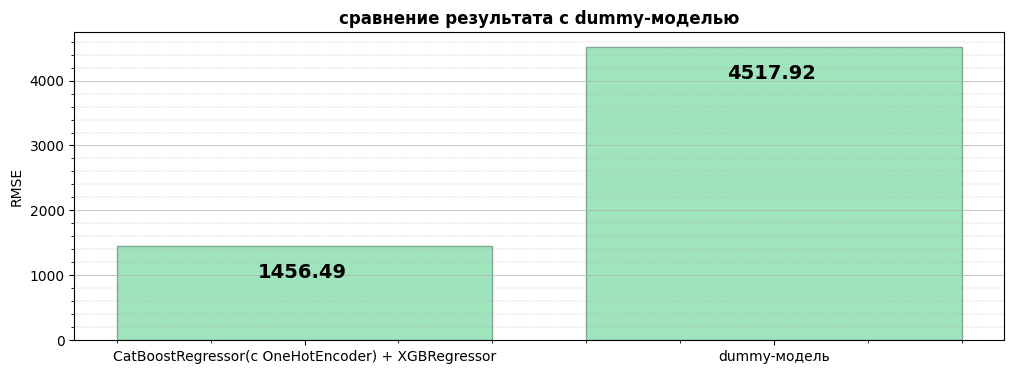

In [78]:
dummy_regr = DummyRegressor(strategy='mean')

time_fit = time.time()
dummy_regr.fit(X_train, y_train)
time_fit = format_time(time.time() - time_fit)

time_predict = time.time()
y_pred_dummy = dummy_regr.predict(X_test)
dummy_regr.fit(X_train, y_train)
time_predict = format_time(time.time() - time_predict)

table_row = GetFinalTable('dummy-модель', '', mean_squared_error(y_test, y_pred_dummy, squared=False),
                          '', time_fit, time_predict)
compare_result = table_row.pivot_table.drop(columns=['RMSE на train', 'время на GridSearch']).iloc[[-2, -1]]
display(compare_result)
get_bar(compare_result['модель'], compare_result['RMSE на test'], '', 'RMSE', 
        'сравнение результата с dummy-моделью', rmse_=compare_result['RMSE на test'].values)

Сравнивая полученный результат нашей композиции моделей со средним от dimmy-заглушки мы окончательно убеждаемся в том, что наш алгоритм работает и довольно прилично улавливает зависимости в данных, предсказывая цены на авто.

Напоследок - сохраним обученные пайплайны для будущих работ:

In [79]:
folder_name = 'pipelines'
try:
    os.mkdir(folder_name)
except FileExistsError:
    pass

joblib.dump(pipeline_and_predicts_list[6][1], os.path.join(folder_name, f'pipeline_CatBoost'))
joblib.dump(pipeline_and_predicts_list[5][1], os.path.join(folder_name, f'pipeline_XGB'))

### Предварительный вывод. На данном этапе мы:

- проанализировали модели, полученные ранее, с точки зрения скорости их работы и качества предсказания
- в борьбе с возможным переобучением составили попарные ансамбли всех разработанных моделей
- выбрали лучший ансамбль, получили по нему предсказание на отложенной выборке
- проверили разработанный алгоритм на адекватность, сравнив полученный результат с константным предсказанием модели-заглушки
- сохранили обученный пайплайны в файлы, в дальнейшем к ним можно юудет обращаться

_____

## Общий вывод

По запросу немецкого (как выяснилось) сервиса по продаже автомобилей с пробегом «Не бит, не крашен» мы раработали Machine Learning-модель, которая подсказывает рыночную стоимость автомобиля клиентам сервиса, публикующим свои анкеты на продажу авто. Модель должна стать конкурентным преимуществом сервиса, упростить пользователям работу с ним и, как следствие, не только повысить лояльность существующих клиентов, но и в потенциале привлечь новых.

С целью понимания рынка автомобильных объявлений при работе с данными были изучены дополнительные материалы из открытых интернет-источников. Гиперссылки на некоторые материалы в работе прикреплены. А для разработки модели нами были проделаны следующие шаги:
- исследованы предоставленные данные
- обработаны различные аномалии в данных
- для улучшения предсказательной силы моделей на основе имеющихся признаков сформированы новые, к примеру такие, как возраст автомобиля, пробег в год и др.
- подготовлены разные виды моделей машинного обучения, а именно рассмотрены алгоритмы:
  - 3 линейных:
    - LinearRegression
    - Ridge
    - Lasso
  - 4 деревянных (бустинги):
    - GradientBoostingRegressor
    - LGBMRegressor
    - XGBRegressor
    - CatBoostRegressor c OneHotEncoder
    - CatBoostRegressor c внутренним обработчиком категориальных переменных
- на базе подготовленных ML-моделей алгоритмов созданы их попарные ансамбли и в итоге выбрана лучшая пара, которая стала основой предлагаемого нами решения 

Что могло помешать исследованию:
- странная картина с датами. Данные были предоставлены за 2 года, однако 350000 объявлений выгружались из базы не ежедневно и оригинальных дней, в которые создавались бы объявления, всего 109. Было бы неплохо уточнить у сотрудников, отвечающих за формирование базы, условия и правила её выгрузки, а иначе может казаться, будто данные нам предоставлены не все.
- большое количество некорректой информации в предоставленной базе, как, например, цены авто по 1-5 евро или указание мощности в лошадиных силах, сравнимое с мощностью грузового танкера. Наличие в базе такого рода данных может свидетельствовать о каких-то сбоях с сборе/обработке/хранении информации
- отсутствие некоторой информации, касающейся в первую очередь важных для продажи характеристик автомобилей, к примеру, был ли ремонт авто или какая у автомобиля модель. Скорее всего, эти поля заполняют сами пользователи и, конечно, заставлять их заполнять все технические характеристики автомобиля было бы неправильно. Но, возможно, стоит как-то подсветить данные поля, может быть пользователи просто не обращают на них внимание. Данный вопрос требует проработки.
- отсутвтие некоторых признаков, на которые потенциальные покупатели подержанных автомобилей часто обращают внимание, к примеру, дата ближайшего техосмотра или количество предыдущих владеьлцев, есть ли регистрация в Германии и т.п. Любая дополнительная информация при разработке модели сыграла бы в плюс.

Несмотря на возникшие к данным вопросы, нам удалось подготовить модель, которая предсказывает цену автомобиля, возвращая значение ошибки предсказания MSE = 1426 евро. Для сравнения - предсказание по среднему даёт значение ошибка аж в 4517 евро, так что наша модель работает, да ещё как.

$\Rightarrow$ наша модель поможет привлечь новых клиентов сервису Не бит, не крашен» и укрепить его позиции на рынке автомобильных объявлений.

_____